In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import os
import torch
import torch.utils.data as data
from torchvision import datasets, models, transforms
from sklearn.model_selection import train_test_split
import zipfile
import shutil
import matplotlib.pyplot as plt
import random
from collections import OrderedDict
from torch.autograd import Variable
from PIL import Image
from torch.optim import lr_scheduler
import copy
from os.path import exists
from torchvision.datasets import ImageFolder

In [ ]:
# mount the Google Drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
zipfile_path = '/content/drive/MyDrive/PlantDiseaseImages/archive.zip'
with zipfile.ZipFile(zipfile_path,'r') as f:
  f.extractall('.')

In [ ]:
np.random.seed(41) # setting the random seed to be able to reproduce results


train_dir = '/content/drive/MyDrive/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
validation_dir = '/content/drive/MyDrive/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid'
test_dir = '/content/drive/MyDrive/Leaves Fixed'

# Verify that each directory contains the correct classes
train_classes = os.listdir(train_dir)
validation_classes = os.listdir(validation_dir)
print('Classes in train directory: ', train_classes)
print('Classes in validation directory: ', validation_classes)


def three_data_augmentations_function(image): # ADD GREY BLOCK, APPLY RANDOM OR CENTER CROP, OR NONE
    rand_num1 = round(random.random(), 3)
    if (rand_num1 < 0.05): # ADD GREY BLOCK
        block_size = 50    # Adjust the block size as desired
        height, width = image.size[1], image.size[0]
        x = torch.randint(0, width - block_size, (1,))
        y = torch.randint(0, height - block_size, (1,))

        # Apply paste operation on the input image
        image.paste((128, 128, 128), (x.item(), y.item(), x.item() + block_size, y.item() + block_size))
        return image

    elif (0.05 <= rand_num1 < 0.1):  # APPLY RANDOM CROP
        return transforms.RandomCrop(size=180)(image)

    elif (0.1 <= rand_num1 < 0.15):  # APPLY CENTER CROP
        return transforms.CenterCrop(size=180)(image)
    return image

# Define the transformation to add Gaussian noise
def add_gaussian_noise(image):
    mean = 0.0
    std = 0.9  # Adjust the standard deviation as desired
    rand_num2 = round(random.random(), 3)
    if rand_num2 < 0.05:
      noise = torch.randn_like(image) * std + mean
      noisy_image = torch.clamp(image + noise, min=0.0, max=1.0)
      return noisy_image
    return image

# Define the transformations to be applied to the images
data_transforms = {
    'train': transforms.Compose([
        transforms.Lambda(three_data_augmentations_function),
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        transforms.Lambda(add_gaussian_noise),

        # Add other transformations if desired
        # transforms.RandomResizedCrop(224),
        # transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
        # transforms.RandomHorizontalFlip(),
        # transforms.RandomRotation(30),
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


# Load the 3 datasets using ImageFolder and apply transformations
train_data = datasets.ImageFolder(train_dir, transform = data_transforms['train'])
validation_data = datasets.ImageFolder(validation_dir, transform = data_transforms['valid'])
test_data = datasets.ImageFolder(test_dir, transform = data_transforms['test'])

Classes in train directory:  ['Corn_(maize)___Northern_Leaf_Blight', 'Potato___Late_blight', 'Potato___Early_blight', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Late_blight', 'Tomato___Tomato_mosaic_virus', 'Strawberry___healthy', 'Grape___Black_rot', 'Corn_(maize)___healthy', 'Peach___healthy', 'Pepper,_bell___healthy', 'Blueberry___healthy', 'Tomato___Target_Spot', 'Orange___Haunglongbing_(Citrus_greening)', 'Raspberry___healthy', 'Tomato___Early_blight', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Tomato___Leaf_Mold', 'Tomato___Bacterial_spot', 'Corn_(maize)___Common_rust_', 'Grape___healthy', 'Apple___Cedar_apple_rust', 'Grape___Esca_(Black_Measles)', 'Cherry_(including_sour)___Powdery_mildew', 'Pepper,_bell___Bacterial_spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Squash___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Apple___Apple_scab', 'Tomato___healthy', 'Tomato___Septoria_leaf_spot', 'Peach___Bacterial_spot', 'Potato___healthy', 'Soybean___heal

In [ ]:
# define dataloader parameters
batch_size  = 128
num_workers = 0

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size,
                                          num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                          num_workers=num_workers, shuffle=True)

# Print the number of images in each set
print( 'Number of training images: ', len(train_data))
print( 'Number of validation images: ', len(validation_data))
print( 'Number of test images: ', len(test_data))


Number of training images:  70305
Number of validation images:  17572
Number of test images:  75


In [ ]:
# Skip connections
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.name = "CNN"
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=2)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=2)
        self.conv6 = nn.Conv2d(256, 512, kernel_size=3, stride=2)
        self.conv7 = nn.Conv2d(512, 1024, kernel_size = 3, stride =2)
        self.conv8 = nn.Conv2d(1024, 2048, kernel_size = 1, stride =1)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p = 0.3)
        self.flatten = nn.Flatten()
        self.norm1 = nn.LayerNorm(3000)
        self.norm2 = nn.LayerNorm(500)
        self.fc1 = nn.Linear(2048, 3000)
        self.fc2 = nn.Linear(3000, 500)
        self.fc3 = nn.Linear(500, 38)

    def forward(self, x):
        self.skip_connections = []  # Reset the skip connections

        # Convolutional layers with skip connections
        x = self.conv1(x)
        self.skip_connections.append(x)
        x = self.relu(x)
        x = self.conv2(x)
        self.skip_connections.append(x)
        x = self.relu(x)
        x = self.conv3(x)
        self.skip_connections.append(x)
        x = self.relu(x)
        x = self.conv4(x)
        self.skip_connections.append(x)
        x = self.relu(x)
        x = self.conv5(x)
        self.skip_connections.append(x)
        x = self.relu(x)
        x = self.conv6(x)
        self.skip_connections.append(x)
        x = self.relu(x)
        x = self.conv7(x)
        self.skip_connections.append(x)
        x = self.relu(x)
        x = self.conv8(x)
        self.skip_connections.append(x)
        x = self.relu(x)

        # Flatten the tensor for fully connected layers
        x = torch.flatten(x, start_dim=1)

        # Fully connected layers
        x = self.fc1(x)
        x = self.relu(x)
        x = self.norm1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.norm2(x)
        x = self.dropout(x)
        x = self.fc3(x)

        return x

In [ ]:
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.name = "CNN2"
        self.conv1 = nn.Conv2d(3, 16, kernel_size=6, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=2)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=2)
        self.conv6 = nn.Conv2d(256, 512, kernel_size=3, stride=2)

        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(2048, 38)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.relu(self.conv5(x))
        x = self.relu(self.conv6(x))

        x = self.flatten(x)
        x = self.fc(x)

        return x

In [ ]:
def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        if use_cuda and torch.cuda.is_available():
              inputs = inputs.cuda()
              labels = labels.cuda()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
    loss = float(total_loss) / (i + 1)
    return loss


In [ ]:
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

In [ ]:
#from tutorial 3a
def get_accuracy(model, dataset_acc):
    correct = 0
    total = 0
    for imgs, labels in dataset_acc:


        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################


        output = model(imgs)


        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [ ]:
# To save the model state in the case that runtime crashes

def save_checkpoint(model, optimizer, epoch, best_accuracy, filepath):
    checkpoint = {
        'epoch': epoch,
        'best_accuracy': best_accuracy,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(checkpoint, filepath)

In [ ]:
use_cuda = False

def train_net(net, training_set, validation_set, batch_size=64, learning_rate=0.01, num_epochs=30, weight_decay = 0.001, checkpoint_filepath=None):
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=True)
    ########################################################################
    # Define the Loss function and optimizer
    # the neural network and scalar label.
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr= learning_rate, weight_decay = weight_decay)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    training_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    training_acc = np.zeros(num_epochs)
    validation_acc = np.zeros(num_epochs)
    best_accuracy = 0.0
    best_param = None
    model_path = None
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.

    if checkpoint_filepath is not None:
        checkpoint = torch.load(checkpoint_filepath)
        net.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        best_accuracy = checkpoint['best_accuracy']
        start_epoch = checkpoint['epoch'] + 1
        print("Resuming training from epoch", start_epoch)
    else:
        start_epoch = 0

    for epoch in range(start_epoch, num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        n = 0
        for imgs, labels in iter(train_loader):
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################
            out = net(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch
            # Calculate the statistics
            n += 1
            total_train_loss += loss.item()
            total_epoch += len(labels)
        del imgs, labels
        torch.cuda.empty_cache()
        # track accuracy
        training_acc[epoch] = get_accuracy(net, train_loader)
        training_loss[epoch] = float(total_train_loss) / (n+1)
        validation_acc[epoch] = get_accuracy(net, val_loader)
        val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Training acc: {} |" + " Validation acc: {}").format(epoch, training_acc[epoch], validation_acc[epoch]))
        if validation_acc[epoch] > best_accuracy:
          best_accuracy = validation_acc[epoch]
          best_params = net.state_dict()  # Save the current model's parameters
          model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
          save_checkpoint(net, optimizer, epoch, best_accuracy, model_path)

    print("best acc: ", best_accuracy)
    epochs = np.arange(1, num_epochs + 1)
    return epochs, training_acc, training_loss, validation_acc, val_loss

With a large batch size (e.g. the entire small dataset) and learning rate that is not too high, we should be able to obtain a 100% training accuracy on the small dataset we got relatively quickly (ie. within 200 iterations).

In [ ]:
import matplotlib.pyplot as plt
def plotting (epochs, train_acc, train_loss, val_acc, val_loss):
  plt.title("Training Curve")
  plt.plot(epochs, train_acc, label="Train")
  plt.plot(epochs, val_acc, label="Validation")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend(loc='best')
  plt.show()

  plt.title("Losses Curve")
  plt.plot(epochs, train_loss, label="Train")
  plt.plot(epochs, val_loss, label="Validation")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

In [ ]:
# Now run actual model but with batch size 128
skip_model = CNN()
if use_cuda and torch.cuda.is_available():
  skip_model.cuda()

epochs, training_acc, training_loss, validation_acc,  val_loss = train_net(skip_model, train_data , validation_data , num_epochs= 15, batch_size= 128, learning_rate=0.001)

Epoch 0: Training acc: 0.5405363112596913 | Validation acc: 0.5718757113589802
Epoch 1: Training acc: 0.7482751262536453 | Validation acc: 0.7765194627816981
Epoch 2: Training acc: 0.8224198022618963 | Validation acc: 0.8384930571363532
Epoch 3: Training acc: 0.8881428266590796 | Validation acc: 0.894832688367858
Epoch 4: Training acc: 0.9152571306636318 | Validation acc: 0.9171409059867972
Epoch 5: Training acc: 0.9130805889465823 | Validation acc: 0.9138971090371045
Epoch 6: Training acc: 0.9340209118713991 | Validation acc: 0.930628272251309
Epoch 7: Training acc: 0.9528700476563056 | Validation acc: 0.947245618028682
Epoch 8: Training acc: 0.9526566612134576 | Validation acc: 0.9436603687684954
Epoch 9: Training acc: 0.9555302653104772 | Validation acc: 0.9446278169815616
Epoch 10: Training acc: 0.9484600611707803 | Validation acc: 0.9362053266560437
Epoch 11: Training acc: 0.9633828864072836 | Validation acc: 0.9508308672888687
Epoch 12: Training acc: 0.9690447400241838 | Validati

ValueError: ignored

In [ ]:
# Now run actual model but with batch size 128
skip_model = CNN()
if use_cuda and torch.cuda.is_available():
  skip_model.cuda()

path = '/content/model_CNN_bs128_lr0.001_epoch12'
epochs, training_acc, training_loss, validation_acc,  val_loss = train_net(skip_model, train_data , validation_data , num_epochs= 30, batch_size= 128, learning_rate=0.001, checkpoint_filepath = path)

Resuming training from epoch 13
Epoch 13: Training acc: 0.9662564905043033 | Validation acc: 0.9556681083541999
Epoch 14: Training acc: 0.9666974891528558 | Validation acc: 0.9527088549965855


In [ ]:
# Now run actual model but with batch size 128
skip_model = CNN()
if use_cuda and torch.cuda.is_available():
  skip_model.cuda()

epochs, training_acc, training_loss, validation_acc,  val_loss = train_net(skip_model, train_data , validation_data , num_epochs= 25, batch_size= 128, learning_rate=0.001)

Epoch 0: Training acc: 0.5083291841525002 | Validation acc: 0.5316412474391077
Epoch 1: Training acc: 0.7586599331389146 | Validation acc: 0.7871613931254268
Epoch 2: Training acc: 0.8489508499893307 | Validation acc: 0.8613134532210335
Epoch 3: Training acc: 0.8990539867700406 | Validation acc: 0.9029706351012975
Epoch 4: Training acc: 0.9087701828010527 | Validation acc: 0.9124174823582973
Epoch 5: Training acc: 0.9321146596486236 | Validation acc: 0.9295470066014113
Epoch 6: Training acc: 0.9320150793086279 | Validation acc: 0.9273844753016162
Epoch 7: Training acc: 0.9426701756881712 | Validation acc: 0.9393922148873207
Epoch 8: Training acc: 0.9521018564620528 | Validation acc: 0.9466196221261097
Epoch 9: Training acc: 0.9507646347535387 | Validation acc: 0.9441725472342363
Epoch 10: Training acc: 0.9468810014937051 | Validation acc: 0.9407580241292967
Epoch 11: Training acc: 0.9540792374991109 | Validation acc: 0.9426360118370134
Epoch 12: Training acc: 0.9636816274272708 | Valid

In [ ]:
file_path_array1 = '/content/epoch.npy'
file_path_array2 = '/content/training_acc.npy'
file_path_array3 = '/content/training_loss.npy'
file_path_array4 = '/content/validation_acc.npy'
file_path_array5 = '/content/val_loss.npy'

# Save the arrays to the specified file paths
np.save(file_path_array1, epochs)
np.save(file_path_array2, training_acc)
np.save(file_path_array3, training_loss)
np.save(file_path_array4, validation_acc)
np.save(file_path_array5, val_loss)

In [ ]:
file_path_array1 = '/content/epoch.npy'
file_path_array2 = '/content/training_acc.npy'
file_path_array3 = '/content/training_loss.npy'
file_path_array4 = '/content/validation_acc.npy'
file_path_array5 = '/content/val_loss.npy'
# Load the arrays from the specified file paths
epoch = np.load(file_path_array1)
training_acc = np.load(file_path_array2)
training_loss = np.load(file_path_array3)
validation_acc = np.load(file_path_array4)
val_loss = np.load(file_path_array5)

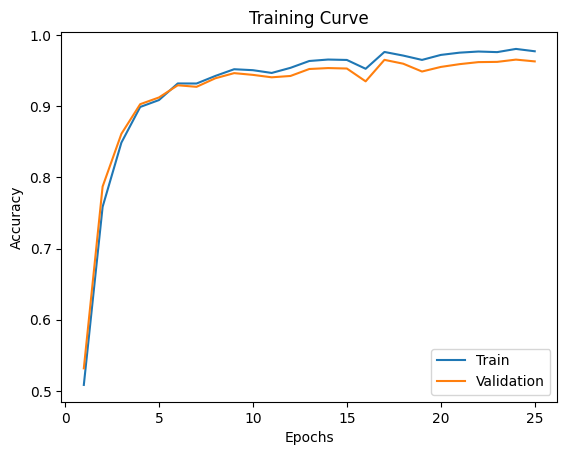

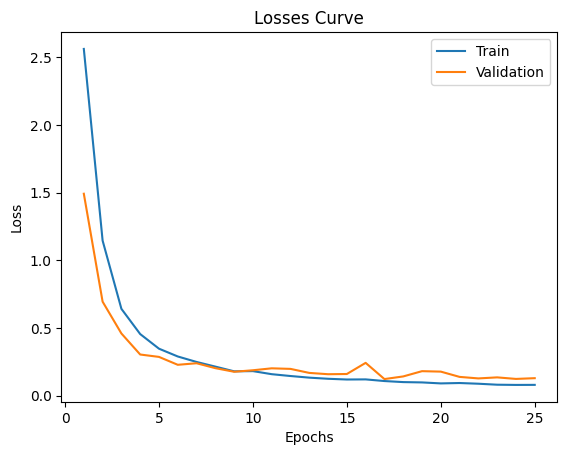

In [ ]:
plotting (epochs, training_acc, training_loss, validation_acc, val_loss)

In [ ]:
# Now run actual model but with batch size 128
skip_model = CNN()
if use_cuda and torch.cuda.is_available():
  skip_model.cuda()
path = '/content/model_CNN_bs128_lr0.001_epoch23'
epochs_1, training_acc_1, training_loss_1, validation_acc_1,  val_loss_1 = train_net(skip_model, train_data , validation_data , num_epochs= 35, batch_size= 128, learning_rate=0.001, checkpoint_filepath = path)

Resuming training from epoch 24
Epoch 24: Training acc: 0.970837186144107 | Validation acc: 0.9565217391304348
Epoch 25: Training acc: 0.9765274912867202 | Validation acc: 0.9624971545640792
Epoch 26: Training acc: 0.978576001138061 | Validation acc: 0.9649442294559527
Epoch 27: Training acc: 0.9778078099438082 | Validation acc: 0.9624402458456636
Epoch 28: Training acc: 0.983939113734974 | Validation acc: 0.9679603915319827
Epoch 29: Training acc: 0.9792588377551746 | Validation acc: 0.9607329842931938
Epoch 30: Training acc: 0.9814922825236503 | Validation acc: 0.9673343956294104
Epoch 31: Training acc: 0.9833131801692866 | Validation acc: 0.970919644889597
Epoch 32: Training acc: 0.9854754961234796 | Validation acc: 0.9696107443660369
Epoch 33: Training acc: 0.985006045949214 | Validation acc: 0.9661962212610972
Epoch 34: Training acc: 0.9854612703606231 | Validation acc: 0.9708627361711815
best acc:  0.970919644889597


In [ ]:
# Now run actual model but with batch size 128
skip_model = CNN()
if use_cuda and torch.cuda.is_available():
  skip_model.cuda()
path = '/content/model_CNN_bs128_lr0.001_epoch31'
epochs_2, training_acc_2, training_loss_2, validation_acc_2,  val_loss_2 = train_net(skip_model, train_data , validation_data , num_epochs= 50, batch_size= 128, learning_rate=0.001, checkpoint_filepath = path)

Resuming training from epoch 32
Epoch 32: Training acc: 0.9812219930293762 | Validation acc: 0.9638060550876394
Epoch 33: Training acc: 0.9801123835265666 | Validation acc: 0.968244935124061
Epoch 34: Training acc: 0.9850344974749271 | Validation acc: 0.9686432961529706
Epoch 35: Training acc: 0.9837115015292696 | Validation acc: 0.9661393125426816


In [ ]:
model = CNN()
# if use_cuda and torch.cuda.is_available():
#   model.cuda()
path = '/content/drive/MyDrive/model_CNN_bs128_lr0.001_epoch31'
epochs_2, training_acc_2, training_loss_2, validation_acc_2,  val_loss_2 = train_net(model, train_data , validation_data , num_epochs= 32, batch_size= 128, learning_rate=0.001, checkpoint_filepath = path)

In [ ]:
all_epochs = np.concatenate((epoch, epochs_1[25:]))
all_training_acc = np.concatenate((training_acc, training_acc_1[25:]))
all_training_loss = np.concatenate((training_loss, training_loss_1[25:]))
all_validation_acc = np.concatenate((validation_acc, validation_acc_1[25:]))
all_val_loss = np.concatenate((val_loss, val_loss_1[25:]))

In [ ]:
plotting (all_epochs, all_training_acc, all_training_loss, all_validation_acc, all_val_loss)

In [ ]:
test_dir = '/content/drive/MyDrive/Leaves-2'

test_data = datasets.ImageFolder(test_dir, transform = data_transforms['test'])

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                          num_workers=num_workers, shuffle=True)

In [ ]:
def new_get_accuracy(model, dataset_acc):
    correct = 0
    total = 0
    for imgs, labels in dataset_acc:


        #############################################
        #To Enable GPU Usage
        # if use_cuda and torch.cuda.is_available():
        #   imgs = imgs.cuda()
        #   labels = labels.cuda()
        #############################################


        output = model(imgs)


        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [ ]:
# Unmount the current Google Drive
drive.flush_and_unmount()

In [ ]:
# Mount Google Drive again
drive.mount('/content/drive')

Mounted at /content/drive


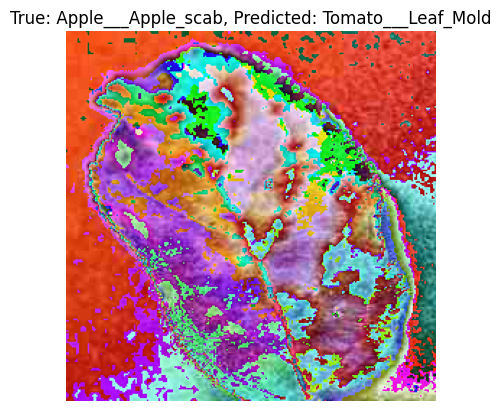

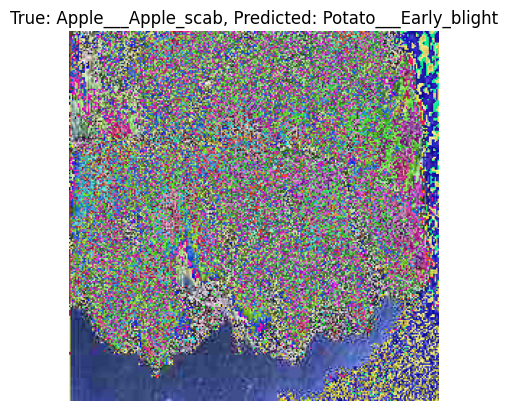

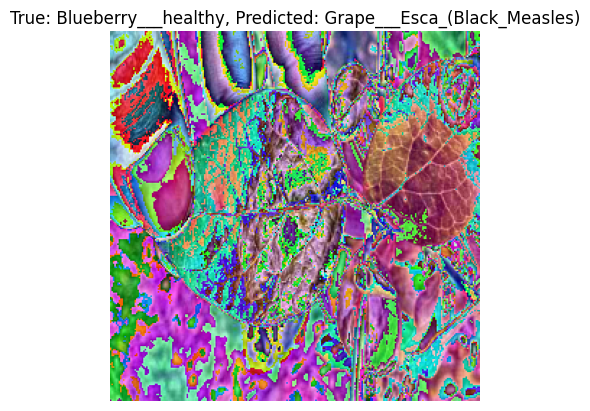

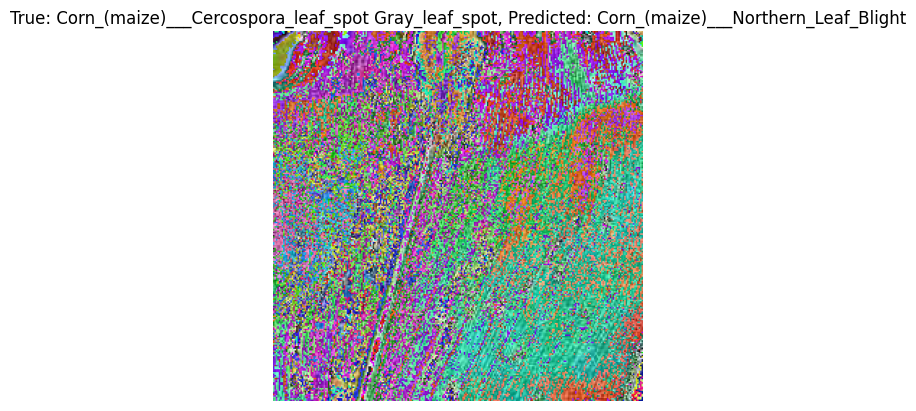

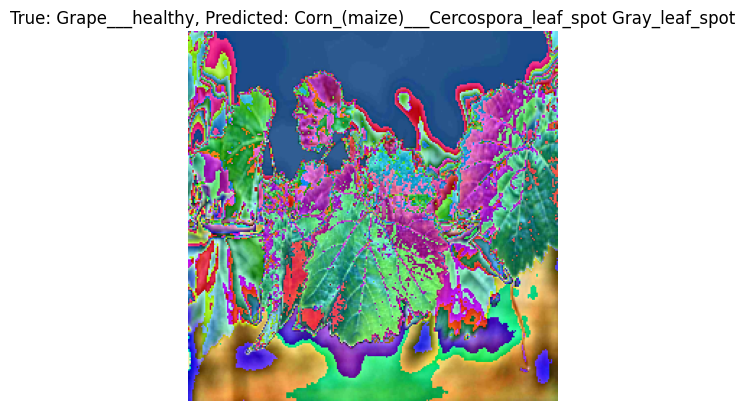

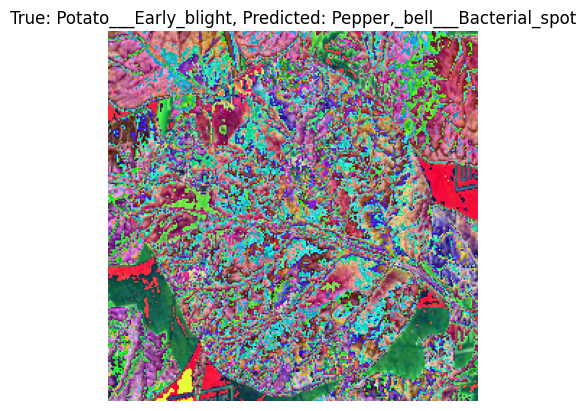

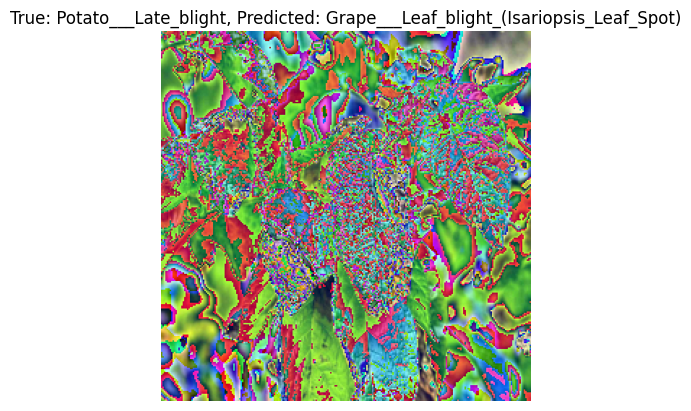

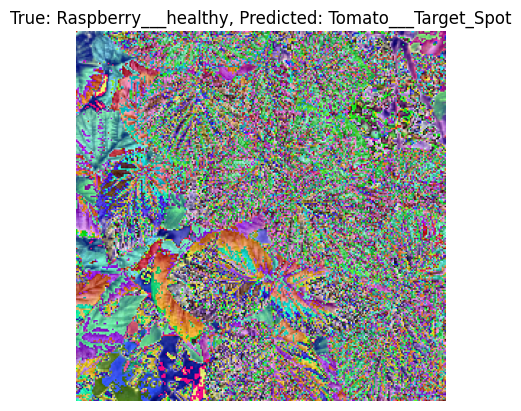

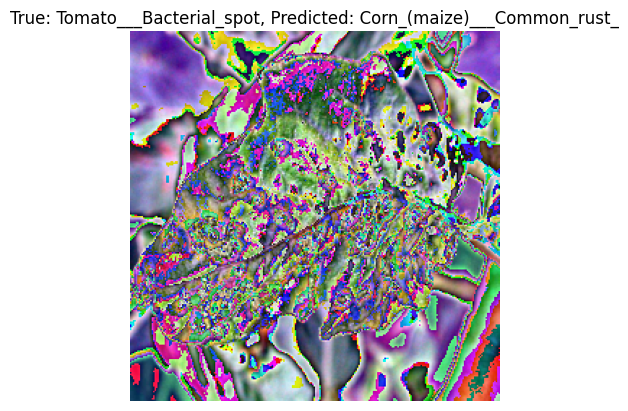

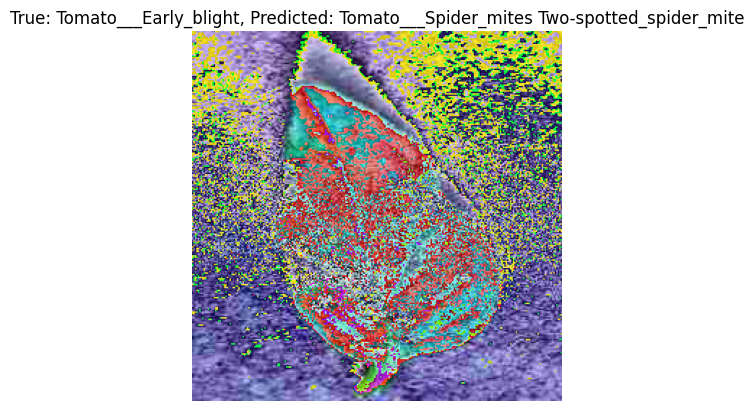

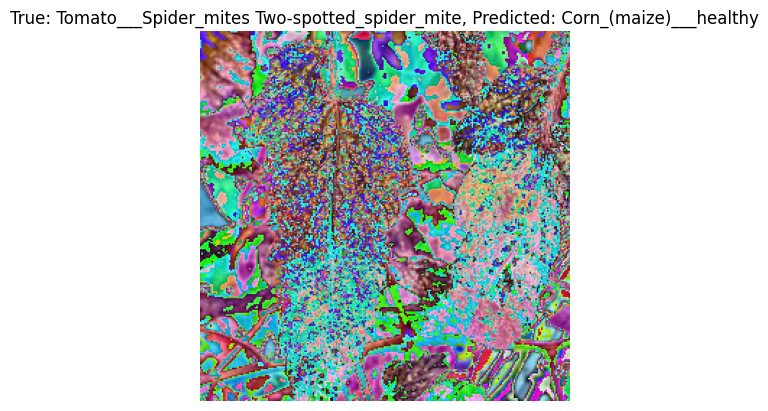

Accuracy:  0.8533333333333334


In [ ]:
from PIL import Image

# Define the desired dimensions
target_size = (256, 256)  # (height, width)

# Load and preprocess the test data
test_data_dir = '/content/drive/MyDrive/Leaves Fixed'

# Define transformations
test_transform = transforms.Compose([
    transforms.Resize(target_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard normalization
])

# Load test dataset
test_dataset = ImageFolder(root=test_data_dir, transform=test_transform)

# Create a data loader for the test dataset
batch_size = 32
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load your trained model
# net = torch.load('/content/drive/MyDrive/model_CNN_bs128_lr0.001_epoch31')
# model.load_state_dict(net['model_state_dict'])
model.eval()  # Set the model to evaluation mode

misclassified_images = []
misclassified_labels = []
misclassified_preds = []

# Evaluate the model on the test set
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        predicted_labels = torch.argmax(outputs, dim=1)

        misclassified_indices = (predicted_labels != labels).nonzero().squeeze()
        misclassified_images.append(images[misclassified_indices])
        misclassified_labels.append(labels[misclassified_indices])
        misclassified_preds.append(predicted_labels[misclassified_indices])

# Concatenate misclassified images, labels, and predictions
misclassified_images = torch.cat(misclassified_images, dim=0)
misclassified_labels = torch.cat(misclassified_labels, dim=0)
misclassified_preds = torch.cat(misclassified_preds, dim=0)

# Print misclassified images
for i in range(len(misclassified_images)):
    misclassified_image = transforms.functional.to_pil_image(misclassified_images[i])
    true_label = test_dataset.classes[misclassified_labels[i]]
    predicted_label = test_dataset.classes[misclassified_preds[i]]

    plt.imshow(misclassified_image)
    plt.title(f"True: {true_label}, Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()

print("Accuracy: ", new_get_accuracy(model, test_loader))


In [ ]:
len(misclassified_images)

11

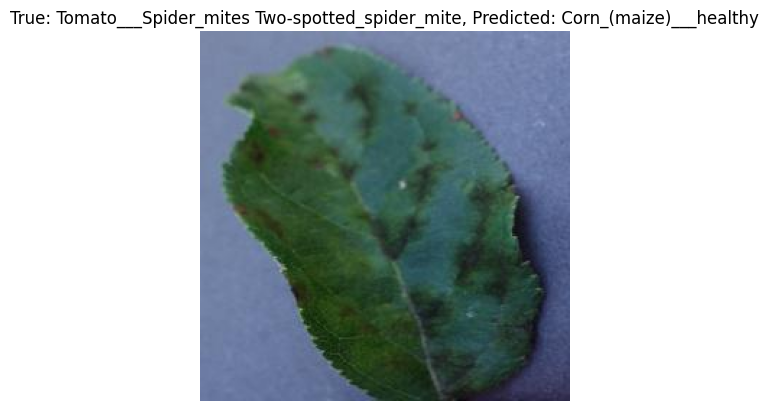

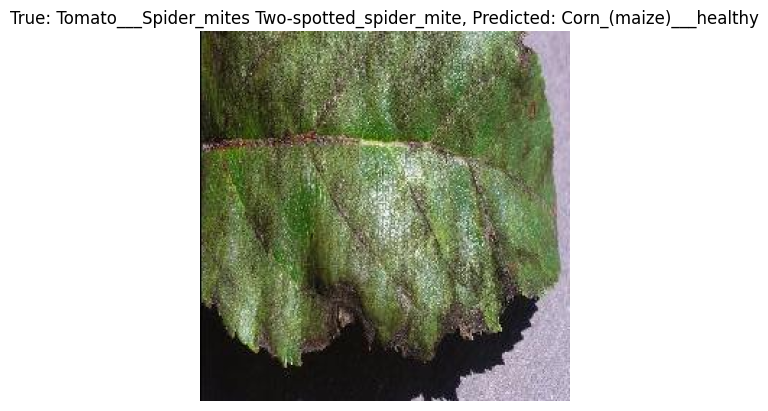

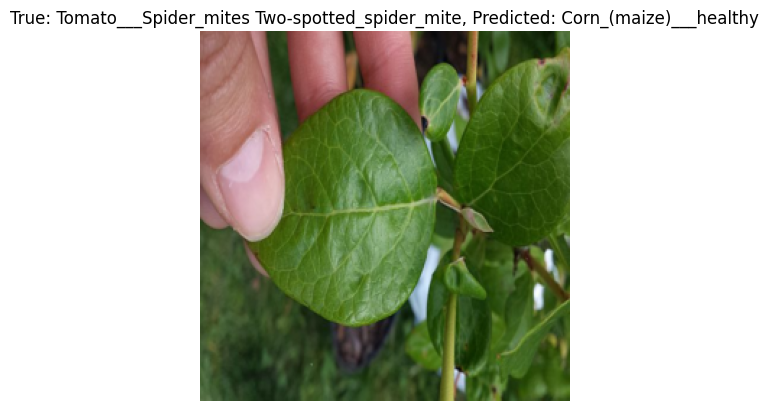

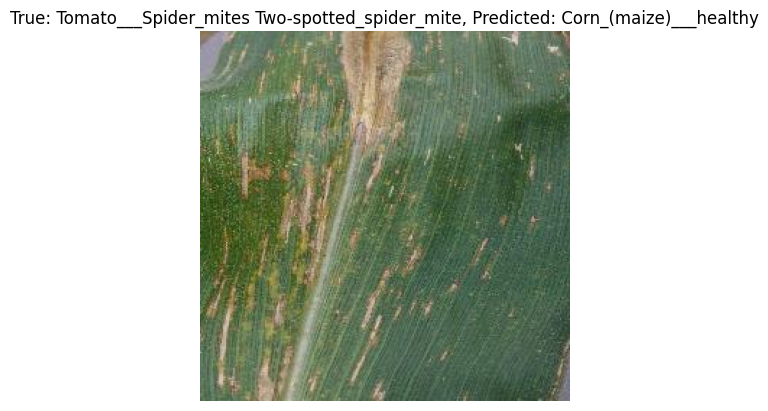

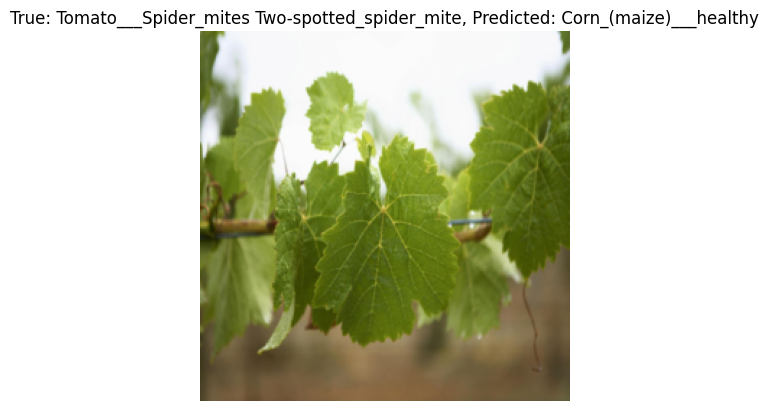

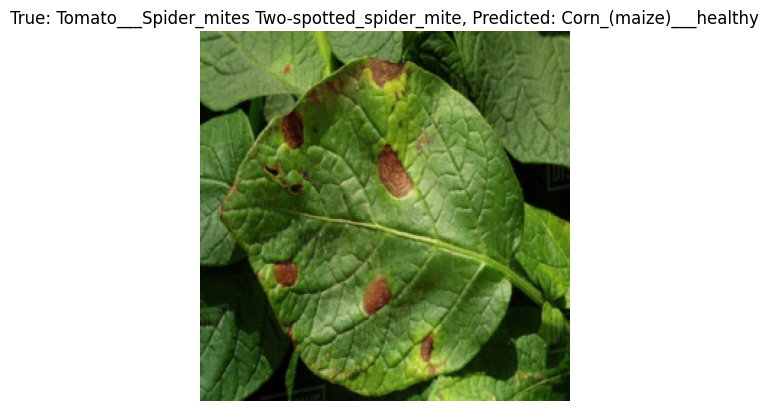

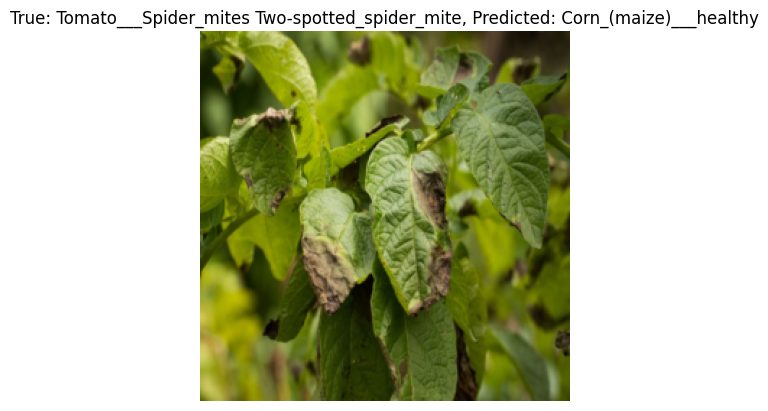

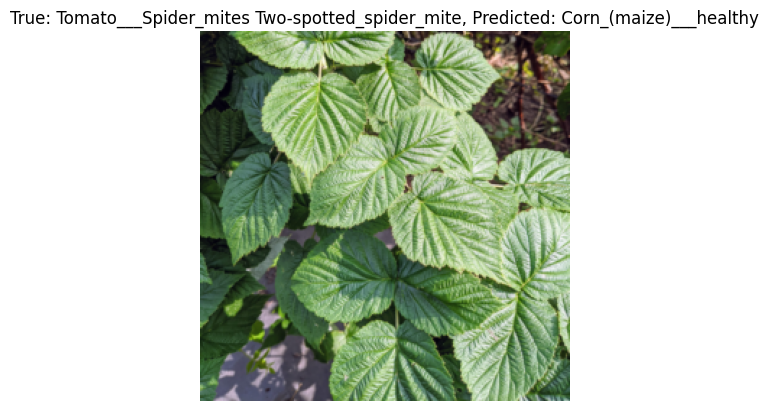

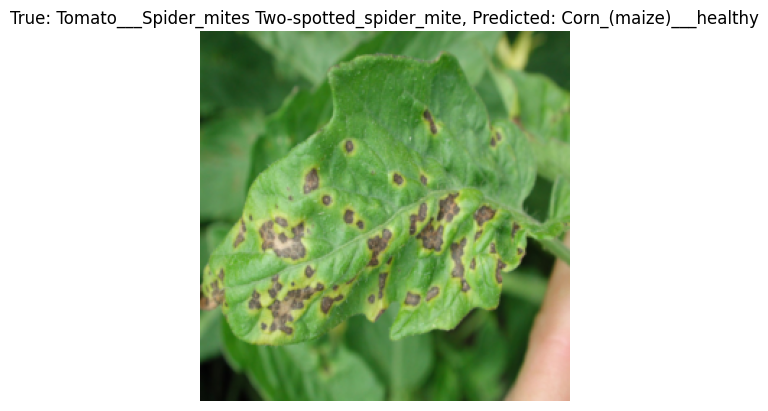

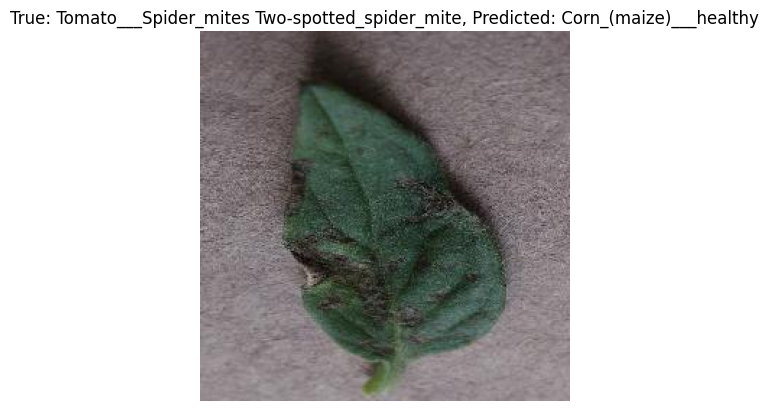

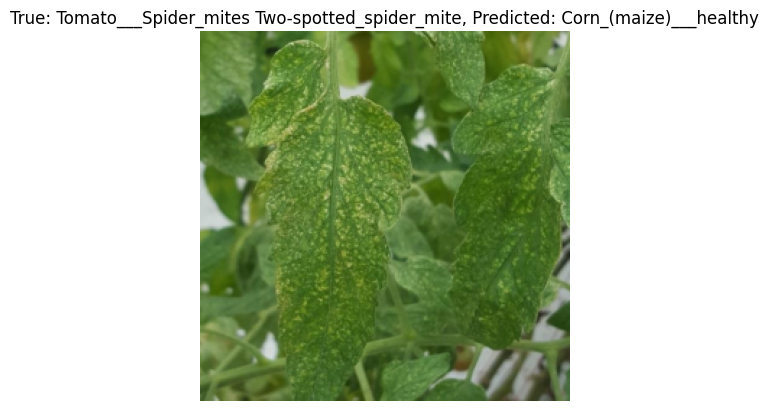

In [ ]:
# Define the mean and std used for normalization
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Display misclassified images using matplotlib
for i in range(len(misclassified_images)):
    # Un-normalize the image
    unnormalized_image = misclassified_images[i] * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)
    unnormalized_image = torch.clamp(unnormalized_image, 0, 1)  # Ensure values are within valid range [0, 1]
    true_label = test_dataset.classes[misclassified_labels[i]]
    predicted_label = test_dataset.classes[misclassified_preds[i]]
    # Convert the unnormalized tensor to a NumPy array
    unnormalized_image_np = unnormalized_image.permute(1, 2, 0).numpy()

    # Display the unnormalized image
    plt.imshow(unnormalized_image_np)
    plt.title(f"True: {true_label}, Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()